In [7]:
#Libraries
import pandas as pd
import numpy as np
import random
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn import svm
import copy
import matplotlib.pyplot as plt

In [8]:
#Dataset Read
dataset_df = pd.read_csv('data/ML.csv')
#dataset_df = dataset_df[~dataset_df.uniq_Op.str.contains("\?")]
df_mu = copy.deepcopy(dataset_df)
df_mu.reset_index(inplace = True,drop = True)

In [9]:
#Mutator Function:
def seen(dataset,parent_candidate):
    size = dataset.shape[0]
    candidate_1 = dataset.loc[random.randint(0,size-1)]
    while candidate_1.equals(parent_candidate):
        candidate_1 = dataset.loc[random.randint(0,size-1)]
    candidate_2 = dataset.loc[random.randint(0,size-1)]
    while candidate_2.equals(parent_candidate) or candidate_1.equals(candidate_2):
        candidate_2 = dataset.loc[random.randint(0,size-1)]
    return parent_candidate,candidate_1,candidate_2
    
def select_candiate(dataset):
    size = dataset.shape[0]
    parent_candidate = dataset.loc[random.randint(0,size-1)]
    return seen(dataset,parent_candidate)

def data_mutator(dataset, f,cr,size):
    dataset.reset_index(inplace = True,drop = True)
    new_candidate = pd.DataFrame()
    dataset_columns = dataset.columns.values
    response_attribute = dataset_columns[len(dataset_columns)-1]
    for i in range(size):
        parent_candidate, child_candidate_1, child_candidate_2 = select_candiate(dataset)
        for key,value in parent_candidate.items():
            if key != response_attribute:
                if isinstance(parent_candidate[key], bool):
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else not parent_candidate[key]
                elif isinstance(parent_candidate[key], str):
                    new_candidate.loc[i,key] = random.choice([parent_candidate[key],child_candidate_1[key],child_candidate_2[key]])
                elif isinstance(parent_candidate[key], list):
                    temp_lst = []
                    for i, each in enumerate(parent_candidate[key]):
                          temp_lst.append(parent_candidate[key][i] if cr < random.random() else
                                          int(parent_candidate[key][i] +
                                              f * (child_candidate_1[key][i] - child_candidate_2[key][i])))
                    new_candidate.loc[i,key] = temp_lst
                else:
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else (
                      abs(parent_candidate[key] + f * (child_candidate_1[key] - child_candidate_2[key])))
            else:
                new_candidate.loc[i,key] = parent_candidate[key]
    return new_candidate

In [10]:
# Score generator
class counter():
    
    def __init__(self, before, after, indx):
        self.indx = indx
        self.actual = before
        self.predicted = after
        self.TP, self.TN, self.FP, self.FN = 0, 0, 0, 0
        for a, b in zip(self.actual, self.predicted):
            if a == indx and b == indx:
                self.TP += 1
            elif a == b and a != indx:
                self.TN += 1
            elif a != indx and b == indx:
                self.FP += 1
            elif a == indx and b != indx:
                self.FN += 1
            elif a != indx and b != indx:
                pass


    def stats(self):
        pd, pf, prec, F, G, acc = 0, 0, 0, 0, 0,0
        if self.TP + self.FN:
            pd = self.TP / (self.TP + self.FN)
        if self.FP+self.TN:
            pf = self.FP/(self.FP+self.TN)
        if self.TP+self.FP:
            prec = self.TP/(self.TP+self.FP)
        if self.TP+self.FP+self.TN+self.TP:
            acc = (self.TP +self.TN)/(self.TP+self.TN+self.FP+self.FN)
        if pd+prec:
            F = 2*pd*prec/(pd+prec)
        if pd+(1-pf):
            G = 2*pd*(1-pf)/(pd+1-pf)
        return pd, pf,prec,acc,F,G



class ABCD():
    "Statistics Stuff, confusion matrix, all that jazz..."

    def __init__(self, before, after):
        self.actual = before
        self.predicted = after

    def __call__(self):
        uniques = set(self.actual)
        for u in list(uniques):
            yield counter(self.actual, self.predicted, indx=u)

# Calculating Macro goal
def calculate_score_macro(confusion_matrix_all_class):
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp = each.TP
        fn = each.FN
        fp = each.FP
        tn = each.FP
        precision.append(float(tp)/float((tp+fp)))
        recall.append(float(tp)/float((tp+fn)))
    for i in range(len(precision)):
        avg_precision += precision[i]
        avg_recall += recall[i]
    avg_precision = avg_precision/len(precision)
    avg_recall = avg_recall/len(recall)
    avg_f1 = 2*(avg_recall*avg_precision)/(avg_recall+avg_precision)
    return avg_precision, avg_recall, avg_f1

# Calculate Micro goal
def calculate_score_micro(confusion_matrix_all_class):
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp += each.TP
        fn += each.FN
        fp += each.FP
        tn += each.FP
    precision = (float(tp)/float((tp+fp)))
    recall = (float(tp)/float((tp+fn)))
    f1 = 2*(recall*precision)/(recall+precision)
    return precision, recall, f1

# Calculate Weighted goal
def calculate_score_weighted(confusion_matrix_all_class,mutated_test_y):
    total_test_point = len(mutated_test_y)
    uniques = list(set(mutated_test_y))
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp = each.TP
        fn = each.FN
        fp = each.FP
        tn = each.FP
        if(tp+fp > 0):
            precision.append(float(tp)/float((tp+fp)))
        if(tp+fn > 0):
            recall.append(float(tp)/float((tp+fn)))
    for i in range(len(uniques)):
        avg_precision += precision[i]*(mutated_test_y.count(uniques[i]))
        avg_recall += recall[i]*(mutated_test_y.count(uniques[i]))
    avg_precision = avg_precision/total_test_point
    avg_recall = avg_recall/total_test_point
    avg_f1 = 2*(avg_recall*avg_precision)/(avg_recall+avg_precision)
    return avg_precision, avg_recall, avg_f1

In [19]:
# Testing with changing mutation rate ## Working
def run_mutation(df,df_name):
    precision_l, recall_l, f1_l = [],[],[]
    data_x = df.drop(['defects'], axis = 1, inplace = False)
    data_y = df.defects
    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
    clf = MultinomialNB()
    clf.fit(train_x,train_y)
    test_data = pd.concat([test_x,test_y],axis = 1) 
    for i in range(20):
        print('testing with crossover frequency:',i/20)
        new_data = data_mutator(test_data,0.8,0.75,test_data.shape[0]) #mutating train set
        mutated_test_y = new_data['defects'].values
        mutated_test_x = new_data.drop(['defects'], axis = 1, inplace = False)
        predicted = clf.predict(mutated_test_x)
        abcd = ABCD(mutated_test_y, predicted)
        confusion_matrix_all_class = [each for each in abcd()]
        precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(mutated_test_y))
        precision_l.append(precision)
        recall_l.append(recall)
        f1_l.append(f1)
        test_data = new_data
        file_name = df_name.split('.')[0]
        file_extension = df_name.split('.')[1]
        file = file_name + '_' + str(i) + '.' + file_extension
        print(file)
        test_data.to_csv('data/' + file, index=False)


    # Drawing plot for F1 Score
    plt.plot(f1_l)
    plt.title('Context Shift plot for:' + df_name)
    plt.xlabel('F1_Score')
    plt.ylabel('Repeats')
    plt.show()

testing with crossover frequency: 0.0
JDT_0.csv
testing with crossover frequency: 0.05
JDT_1.csv
testing with crossover frequency: 0.1
JDT_2.csv
testing with crossover frequency: 0.15
JDT_3.csv
testing with crossover frequency: 0.2
JDT_4.csv
testing with crossover frequency: 0.25
JDT_5.csv
testing with crossover frequency: 0.3
JDT_6.csv
testing with crossover frequency: 0.35
JDT_7.csv
testing with crossover frequency: 0.4
JDT_8.csv
testing with crossover frequency: 0.45
JDT_9.csv
testing with crossover frequency: 0.5
JDT_10.csv
testing with crossover frequency: 0.55
JDT_11.csv
testing with crossover frequency: 0.6
JDT_12.csv
testing with crossover frequency: 0.65
JDT_13.csv
testing with crossover frequency: 0.7
JDT_14.csv
testing with crossover frequency: 0.75
JDT_15.csv
testing with crossover frequency: 0.8
JDT_16.csv
testing with crossover frequency: 0.85
JDT_17.csv
testing with crossover frequency: 0.9
JDT_18.csv
testing with crossover frequency: 0.95
JDT_19.csv


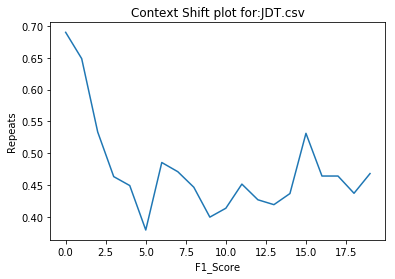

In [21]:
#dataset = ['JDT.csv','jm1.csv','ML.csv','EQ.csv','LC.csv','PDE.csv']
dataset = ['JDT.csv']
for data in dataset:
    #Dataset Read
    dataset_df = pd.read_csv('data/'+data)
    if data == 'jm1.csv':
        dataset_df = dataset_df[~dataset_df.uniq_Op.str.contains("\?")]
    df_mu = copy.deepcopy(dataset_df)
    df_mu.reset_index(inplace = True,drop = True)
    run_mutation(dataset_df,data)